In [3]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

from nb18 import ltv_with_coupons

In [4]:
transactions, customer_features = ltv_with_coupons()
print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,0,0,0,0,5,0,2,2,...,0,3,0,4,0,0,0,0,0,0
1,1,-61,2,0,5,2,3,4,1,0,...,5,0,1,35,11,0,5,2,4,0
2,2,-8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-41,0,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(customer_features.shape)
customer_features.head()

(10000, 5)


,customer_id,region,income,coupons,age
0,0,18,1025,5,24
1,1,40,1649,5,26
2,2,35,2034,15,33
3,3,29,1859,15,35
4,4,11,1243,5,26


In [6]:
def process_data(transactions, customer_data):
    profitable = (transactions[["customer_id"]].assign(net_value=transactions.drop(columns="customer_id").sum(axis=1)))
    return (customer_data
            # join net_value and features
            .merge(profitable, on="customer_id")
            # include the coupons cost
            .assign(net_value = lambda d: d["net_value"] - d["coupons"]))

customer_features = process_data(transactions, customer_features)
customer_features.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,15,33,-23
3,3,29,1859,15,35,-45
4,4,11,1243,5,26,-26


In [7]:
customer_features.groupby("coupons")["customer_id"].count()

coupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

In [8]:
customer_features.corr()[["coupons"]]

,coupons
customer_id,0.002239
region,-0.004073
income,0.001236
coupons,1.000000
age,0.897308
net_value,-0.078369


Text(0.5, 1.0, 'Net Value by Coupon Value')

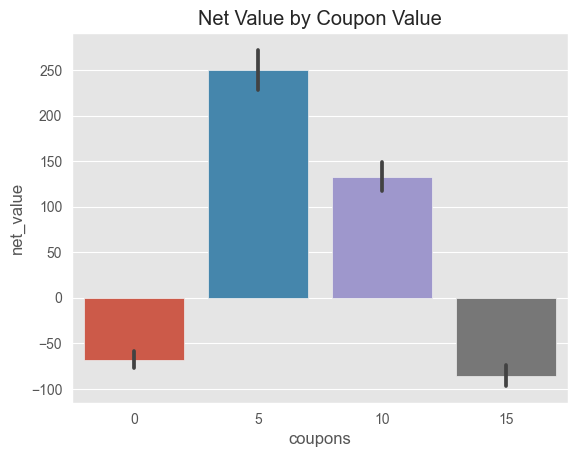

In [9]:
sns.barplot(data=customer_features, x="coupons", y="net_value")
plt.title("Net Value by Coupon Value")

In [10]:
simple_policy = 5 * np.ones(customer_features["coupons"].shape)
transactions_simple_policy, customer_features_simple_policy = ltv_with_coupons(simple_policy)
customer_features_simple_policy = process_data(transactions_simple_policy, customer_features_simple_policy)
customer_features_simple_policy.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,5,24,-44
1,1,40,1649,5,26,74
2,2,35,2034,5,33,63
3,3,29,1859,5,35,63
4,4,11,1243,5,26,-26


In [11]:
simple_policy_gain = customer_features_simple_policy["net_value"].mean()
simple_policy_gain

252.9268

In [12]:
customer_features["net_value"].mean()

165.1066

In [13]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):

    np.random.seed(seed)

    # train the ML model
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])

    # fit the bands
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]

    def predict(test_set):
        # make predictions with trained model
        predictions = reg.predict(test_set[features])

        # discretize predictions into bands.
        pred_bands = np.digitize(predictions, bands, right=False)
        return test_set.assign(predictions=predictions,
                               # cliping avoid creating new upper bands
                               pred_bands=np.clip(pred_bands, 1, n_bands))

    return predict

In [14]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=1)

In [30]:
model_params = {'n_estimators': 150,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"
model = model_bands(train, features, target, model_params, n_bands=10)

C:\Users\Kevin\miniconda3\envs\hihi\lib\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [32]:
model(train).head()

,customer_id,region,income,coupons,age,net_value,predictions,pred_bands
2228,2228,30,567,5,27,-129,-16.296297,2
5910,5910,32,647,5,25,-55,-16.296297,2
1950,1950,31,2953,15,33,-142,102.237797,7
2119,2119,1,2860,5,27,-23,94.291197,7
5947,5947,49,589,5,26,-91,-3.525593,3


In [33]:
print("Train Score:, ", r2_score(train["net_value"], model(train)["predictions"]))
print("Test Score:, ", r2_score(test["net_value"], model(test)["predictions"]))

Train Score:,  0.5382953634651921
Test Score:,  0.504563847410434


Text(0.5, 1.0, 'Net Value by Coupon Value')

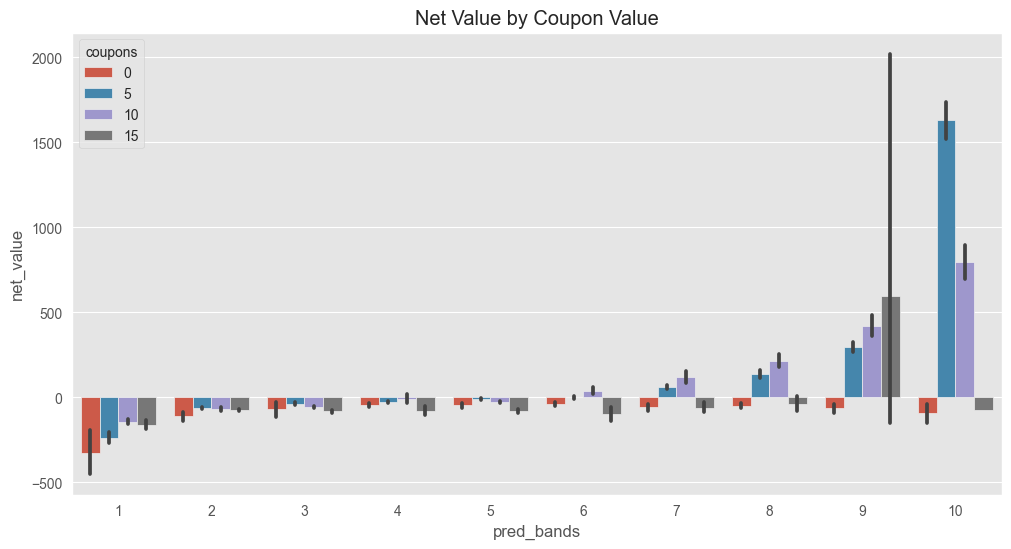

In [34]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(customer_features), x="pred_bands", y="net_value", hue="coupons")
plt.title("Net Value by Coupon Value")

In [35]:
pred_bands = model(customer_features).groupby(["pred_bands", "coupons"])[["net_value"]].mean().reset_index()
pred_bands.head(7)

,pred_bands,coupons,net_value
0,1,0,-324.538462
1,1,5,-237.683871
2,1,10,-142.203390
3,1,15,-160.413223
4,2,0,-108.980769
5,2,5,-63.718650
6,2,10,-68.327146


In [36]:
pred_bands["max_net"] = pred_bands.groupby(['pred_bands'])[["net_value"]].rank(ascending=False)
pred_bands.head(7)

,pred_bands,coupons,net_value,max_net
0,1,0,-324.538462,4.0
1,1,5,-237.683871,3.0
2,1,10,-142.203390,1.0
3,1,15,-160.413223,2.0
4,2,0,-108.980769,4.0
5,2,5,-63.718650,1.0
6,2,10,-68.327146,2.0


In [37]:
best_coupons_per_band = pred_bands.query("max_net==1")[["pred_bands", "coupons"]]
best_coupons_per_band

,pred_bands,coupons
2,1,10
5,2,5
9,3,5
14,4,10
17,5,5
22,6,10
26,7,10
30,8,10
35,9,15
37,10,5


In [38]:
coupons_per_id = (
    model(customer_features)
    .drop(columns=["coupons"])
    .merge(best_coupons_per_band, on="pred_bands")[["customer_id", "coupons"]]
    .sort_values('customer_id')
)

coupons_per_id.head()

,customer_id,coupons
0,0,10
1,1,10
788,2,5
1982,3,10
2743,4,5


In [39]:
transactions_policy_w_model, customer_features_policy_w_model = ltv_with_coupons(
    coupons_per_id[["coupons"]].values.flatten()
)

customer_features_policy_w_model = process_data(transactions_policy_w_model, customer_features_policy_w_model)

customer_features_policy_w_model.head()

,customer_id,region,income,coupons,age,net_value
0,0,18,1025,10,24,-87
1,1,40,1649,10,26,42
2,2,35,2034,5,33,63
3,3,29,1859,10,35,-40
4,4,11,1243,5,26,-26


In [40]:
policy_w_model_gain = customer_features_policy_w_model["net_value"].mean()
policy_w_model_gain

229.9341